<a href="https://colab.research.google.com/github/gundamp/cookbook/blob/main/SQL_Query_for_Triangles_jp_jc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL: Queries to Create Triangles

This notebook was created by Jacky Poon for the [Actuaries' Analytical Cookbook](https://actuariesinstitute.github.io/cookbook/docs/index.html).

## Introduction and Setup

This article describes a method with SQL to convert a transactional claims dataset to a triangle. We will use Python for constructing our dummy dataset, and use ``duckdb`` as our SQL database, but basic concepts should apply similarly to other SQL databases.

In [1]:
!pip install duckdb ## JC
!pip show duckdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 7.1 MB/s 
Name: duckdb
Version: 0.4.0
Summary: DuckDB embedded database
Home-page: https://www.duckdb.org
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: 


Import the libraries:

In [2]:
import pandas as pd
import numpy as np

import duckdb

from matplotlib import pyplot as plt

In [3]:
# start an in-memory database
con = duckdb.connect(database=':memory:')

## Transaction Data

For the example reserving data, we use a simulated dataset from the [SynthETIC](https://arxiv.org/pdf/2008.05693.pdf) R package, with further adjustments to it to make it resemble a real dataset.

DuckDB can [read and query CSVs directly from local files](https://duckdb.org/docs/data/csv) - but with CSV files from the internet it is easier to read it with Python in pandas.

In [4]:
transactions = pd.read_csv(
    "https://raw.githubusercontent.com/JackyP/SyntheticExports/main/synthetic_test_transaction_dataset.csv"
)
transactions

,claim_no,pmt_no,occurrence_period,occurrence_time,claim_size,notidel,setldel,payment_time,payment_period,payment_size,payment_inflated,payment_delay
0,1,1,1,0.623835,785870.789628,0.065163,18.228022,4.197594,5,25104.778182,25631.935128,3.508595
1,1,2,1,0.623835,785870.789628,0.065163,18.228022,7.096012,8,26176.620067,27112.545886,2.898418
2,1,3,1,0.623835,785870.789628,0.065163,18.228022,11.157697,12,26333.186750,27828.701791,4.061685
3,1,4,1,0.623835,785870.789628,0.065163,18.228022,14.445762,15,26341.097381,28293.903794,3.288065
4,1,5,1,0.623835,785870.789628,0.065163,18.228022,18.452453,19,592456.913866,649127.994604,4.006691
...,...,...,...,...,...,...,...,...,...,...,...,...
18978,3624,2,40,39.767468,270737.291484,0.666458,2.920804,41.622132,42,6586.081338,8093.128975,0.670541
18979,3624,3,40,39.767468,270737.291484,0.666458,2.920804,42.081820,43,9716.975065,11967.648057,0.459688
18980,3624,4,40,39.767468,270737.291484,0.666458,2.920804,42.407479,43,7770.338755,9585.568042,0.325659
18981,3624,5,40,39.767468,270737.291484,0.666458,2.920804,43.066655,44,203618.760893,252007.199917,0.659176


This is a transactional dataset with payments. The dataset has times are represented as arbitrary time period units rather than dates, and some additional calculated fields are already available. However, for this exercise, we want to demonstrate how to create these columns in real world situations where the raw datasets are unlikely to include them. So the time periods will be converted to date formats with months from a start date of 2000-01-01 and some columns hidden to create a dataset that resembles real datasets in practice.

In [5]:
# Feel free to skim through this part.
## JC: 28 instead of 30, probably doesn't matter

import datetime
from dateutil.relativedelta import relativedelta

dummy_start_date = datetime.date(2000, 1, 1)

transactions['occurrence_date'] = transactions.apply(
    lambda x: (dummy_start_date + 
               relativedelta(months = int(x['occurrence_time'])) + 
               relativedelta(days = int(x['occurrence_time'] % 1 * 28))
              ), 
    axis = 1
)

transactions['payment_date'] = transactions.apply(
    lambda x: (dummy_start_date + 
               relativedelta(months = int(x['payment_time'])) + 
               relativedelta(days = int(x['payment_time'] % 1 * 28))
              ), 
    axis = 1
)
transactions2 = transactions.loc[
    lambda df: df.payment_time <= 40, 
    ["claim_no", "pmt_no", "occurrence_date", "payment_date", "payment_size"]
]

So we will register this pandas table in SQL and pretend we had a dataset that looks like this:

In [6]:
# register the table in sql
con.register('transactions_view', transactions2)

transactions2

,claim_no,pmt_no,occurrence_date,payment_date,payment_size
0,1,1,2000-01-18,2000-05-06,25104.778182
1,1,2,2000-01-18,2000-08-03,26176.620067
2,1,3,2000-01-18,2000-12-05,26333.186750
3,1,4,2000-01-18,2001-03-13,26341.097381
4,1,5,2000-01-18,2001-07-13,592456.913866
...,...,...,...,...,...
18522,3540,1,2003-03-22,2003-04-15,7408.273603
18523,3540,2,2003-03-22,2003-04-23,7557.339854
18539,3543,1,2003-04-04,2003-04-25,11149.853130
18691,3570,1,2003-04-07,2003-04-26,3354.405206


### Using SQL

Here is the SQL query. It creates accident, development and payment/calendar periods from the dataset, and sums up at that triangle level. Uncomment ``claim_no`` and ``pmt_no`` to get a more detailed view - this is helpful for testing that the logic works also.

In [7]:
con.execute("""
    CREATE OR REPLACE VIEW triangle AS 
    SELECT 
        --claim_no,
        --pmt_no,
        DATE_DIFF('month', DATE '2000-01-01', STRPTIME(occurrence_date, '%Y-%m-%d')) + 1 as occurrence_period,
        DATE_DIFF('month', DATE '2000-01-01', STRPTIME(payment_date, '%Y-%m-%d')) + 1 as payment_period,
        DATE_DIFF('month', DATE '2000-01-01', STRPTIME(payment_date, '%Y-%m-%d')) - 
          DATE_DIFF('month',  DATE '2000-01-01', STRPTIME(occurrence_date, '%Y-%m-%d')) + 1 as development_period,        
        SUM(payment_size) as payments

    FROM 
        transactions_view
    GROUP BY 
        --claim_no,
        --pmt_no,        
        occurrence_period,
        development_period,
        payment_period
        
    ORDER BY
        --claim_no,
        --pmt_no,        
        occurrence_period,
        development_period,
        payment_period
;
        
    SELECT * FROM triangle;
"""
)
triangle = con.fetchdf()
triangle

,occurrence_period,payment_period,development_period,payments
0,1,2,2,46985.029619
1,1,3,3,392545.850638
2,1,4,4,185946.113394
3,1,5,5,700630.302735
4,1,6,6,261024.509136
...,...,...,...,...
765,37,40,4,338030.875016
766,38,39,2,97489.963585
767,38,40,3,259540.894156
768,39,40,2,69383.491649


Whilst the above is perfect for further calculations or export, triangles are often displayed in the "wide" format as follows. Pivotting is easier in pandas in Python or dplyr for R than in SQL.

In [8]:
triangle.pivot(index="occurrence_period", columns="development_period", values="payments")

development_period,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
occurrence_period,,,,,,,,,,,,,,,,,,,,,
1,NaN,46985.029619,392545.850638,1.859461e+05,7.006303e+05,2.610245e+05,3.329688e+05,2.646413e+05,6.057430e+05,1.434176e+05,...,1.771805e+06,507751.595236,1.267975e+06,205780.737653,6226.894042,NaN,5.087788e+05,55918.782513,NaN,412516.399423
2,64334.385165,103991.537490,134383.992047,2.940818e+05,4.868833e+05,2.805029e+06,3.835312e+05,1.475784e+05,2.536358e+05,5.385814e+05,...,8.616884e+04,8745.529181,3.974022e+05,714117.521603,89465.857732,128332.630805,5.301655e+05,349790.454839,12587.59026,90955.620959
3,3142.606330,43202.971210,156562.667084,2.792880e+05,5.374176e+05,4.028233e+05,6.908980e+05,4.429766e+05,7.212855e+05,8.362954e+05,...,NaN,20938.965519,NaN,NaN,19996.986384,NaN,NaN,NaN,NaN,NaN
4,NaN,61865.265714,57298.919248,1.859610e+05,1.862006e+05,1.453144e+05,2.696107e+05,4.480261e+05,1.742546e+05,9.715882e+05,...,4.688630e+05,NaN,6.155031e+05,197934.940768,NaN,NaN,3.830643e+05,NaN,NaN,NaN
5,5346.166482,54954.008437,264498.220981,2.036823e+05,4.472988e+05,2.633055e+05,3.387926e+05,3.150558e+05,7.504150e+05,2.611304e+05,...,1.103665e+05,587681.103745,2.201814e+04,87364.263674,NaN,322793.116875,1.043557e+06,NaN,NaN,NaN
6,4222.377626,117425.751392,537503.282266,4.137136e+05,3.769690e+05,6.769168e+05,1.084063e+06,8.276801e+05,8.531432e+05,2.054070e+05,...,6.795053e+04,NaN,1.900894e+06,NaN,189803.137289,165066.293055,NaN,NaN,NaN,NaN
7,NaN,51733.238185,121187.914637,2.782337e+05,3.766345e+05,5.262455e+05,4.970687e+05,6.972138e+05,7.314588e+05,6.290212e+05,...,1.041520e+04,40683.584878,4.737402e+05,NaN,874535.741565,NaN,NaN,NaN,NaN,NaN
8,NaN,29161.090791,182951.743887,3.381624e+05,2.823336e+05,3.432786e+05,1.183421e+06,9.014267e+05,1.167906e+06,4.107145e+05,...,NaN,493829.570893,3.123278e+05,58747.903282,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,133157.263191,215744.746038,1.374049e+06,7.828536e+05,7.966235e+05,4.644824e+05,9.741834e+05,5.535232e+05,5.008409e+05,...,1.230771e+04,117212.190268,3.179059e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This can also be plotted easily with ``pandas``.

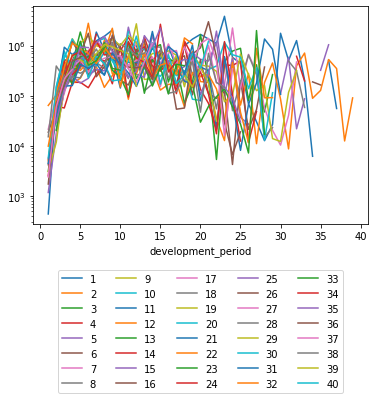

In [9]:
(triangle
    .pivot(index="development_period", columns="occurrence_period", values="payments")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

## Guaranteeing all cells

With the above dataset, records will be missing if they do not have any claims transactions. This can be problematic if the models or calculations later on in the process flow rely on the dataset having every single accident/development period combination. To include these zero cells is not too difficult to implement in SQL.

Firstly, ``duckdb`` allows creating custom "macro" functions as follows:

In [10]:
# Define a fill null function
con.execute("""
    CREATE MACRO FILL_NULL(a, b) AS CASE WHEN a IS NULL THEN b ELSE a END;
""")

The original dataset will be joined to a dummy dataset with the full range of accident/occurence and development periods.

In [12]:
# Dummy table of periods
range_occurrence = pd.DataFrame.from_dict({"occurrence_period": range(1, 40 + 1)})
range_development = pd.DataFrame.from_dict({"development_period": range(1, 40 + 1)})

range_occurrence

,occurrence_period
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [13]:
con.register('range_occurrence_view', range_occurrence)
con.register('range_development_view', range_development)

The join logic can be constructed as follows. First ``full_tri`` is defined which has every combination of occurence and development period, then the original dataset is left joined onto it.

In [14]:
con.execute("""
    CREATE OR REPLACE VIEW triangle_fill AS 
    
    WITH full_tri as (
    SELECT 
        o.occurrence_period,
        d.development_period,
        d.development_period + o.occurrence_period - 1 as payment_period

    FROM 
        range_occurrence_view as o,
        range_development_view as d
    )
    SELECT 
        full_tri.*, 
        FILL_NULL(triangle.payments, 0) as payments
    FROM 
        full_tri

    LEFT JOIN
        triangle
    ON
        full_tri.occurrence_period  = triangle.occurrence_period
    AND full_tri.development_period = triangle.development_period
    AND full_tri.payment_period     = triangle.payment_period
    
    WHERE
        full_tri.payment_period <= 40 
        -- if triangle is cut off at particular calendar period    
;
        
    SELECT * FROM triangle_fill;
"""
)
triangle_fill = con.fetchdf()
triangle_fill

,occurrence_period,development_period,payment_period,payments
0,1,2,2,46985.029619
1,1,3,3,392545.850638
2,1,4,4,185946.113394
3,1,5,5,700630.302735
4,1,6,6,261024.509136
...,...,...,...,...
815,33,1,33,0.000000
816,34,1,34,0.000000
817,35,1,35,0.000000
818,38,1,38,0.000000


Again, here is the triangle. You can see the accident/development cells with no payments are now zero instead of null.

In [15]:
triangle_fill.pivot(index="occurrence_period", columns="development_period", values="payments")

development_period,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
occurrence_period,,,,,,,,,,,,,,,,,,,,,
1,0.000000,46985.029619,392545.850638,1.859461e+05,7.006303e+05,2.610245e+05,3.329688e+05,2.646413e+05,6.057430e+05,1.434176e+05,...,507751.595236,1.267975e+06,205780.737653,6226.894042,0.000000,5.087788e+05,55918.782513,0.00000,412516.399423,0.0
2,64334.385165,103991.537490,134383.992047,2.940818e+05,4.868833e+05,2.805029e+06,3.835312e+05,1.475784e+05,2.536358e+05,5.385814e+05,...,8745.529181,3.974022e+05,714117.521603,89465.857732,128332.630805,5.301655e+05,349790.454839,12587.59026,90955.620959,NaN
3,3142.606330,43202.971210,156562.667084,2.792880e+05,5.374176e+05,4.028233e+05,6.908980e+05,4.429766e+05,7.212855e+05,8.362954e+05,...,20938.965519,0.000000e+00,0.000000,19996.986384,0.000000,0.000000e+00,0.000000,0.00000,NaN,NaN
4,0.000000,61865.265714,57298.919248,1.859610e+05,1.862006e+05,1.453144e+05,2.696107e+05,4.480261e+05,1.742546e+05,9.715882e+05,...,0.000000,6.155031e+05,197934.940768,0.000000,0.000000,3.830643e+05,0.000000,NaN,NaN,NaN
5,5346.166482,54954.008437,264498.220981,2.036823e+05,4.472988e+05,2.633055e+05,3.387926e+05,3.150558e+05,7.504150e+05,2.611304e+05,...,587681.103745,2.201814e+04,87364.263674,0.000000,322793.116875,1.043557e+06,NaN,NaN,NaN,NaN
6,4222.377626,117425.751392,537503.282266,4.137136e+05,3.769690e+05,6.769168e+05,1.084063e+06,8.276801e+05,8.531432e+05,2.054070e+05,...,0.000000,1.900894e+06,0.000000,189803.137289,165066.293055,NaN,NaN,NaN,NaN,NaN
7,0.000000,51733.238185,121187.914637,2.782337e+05,3.766345e+05,5.262455e+05,4.970687e+05,6.972138e+05,7.314588e+05,6.290212e+05,...,40683.584878,4.737402e+05,0.000000,874535.741565,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000000,29161.090791,182951.743887,3.381624e+05,2.823336e+05,3.432786e+05,1.183421e+06,9.014267e+05,1.167906e+06,4.107145e+05,...,493829.570893,3.123278e+05,58747.903282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.000000,133157.263191,215744.746038,1.374049e+06,7.828536e+05,7.966235e+05,4.644824e+05,9.741834e+05,5.535232e+05,5.008409e+05,...,117212.190268,3.179059e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Where to go from here:
As demonstrated, it is fairly straightforward to transform claims data into the right format in SQL and create summaries for claims triangle projections. 

For further analysis in Excel, in Python (similar tools exist in R), ``pandas`` can export to xlsx format with [``to_excel``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_excel.html), or [xlwings](https://www.xlwings.org) can directly control Excel for additional VBA macro-style automation. 

Triangle methods can also be applied directly within Python without exporting to Excel or another tool. Consider for example, [chainladder](https://chainladder-python.readthedocs.io/en/latest/intro.html), a project led out of casact which provides a number of claims development models.  

In [16]:
# JC: Add CDF calculation

In [17]:
# Define a dataframe from the generated triangle

df_triangle_sort = triangle_fill.sort_values(['occurrence_period', 'development_period', 'payment_period'], 
                        ascending=[True, True, True]).reset_index(drop=True)

In [18]:
# Add a column for cumulative payment

df_triangle_sort["payments_cumulative"] = \
           df_triangle_sort.groupby(['occurrence_period'])['payments'] \
           .cumsum(axis = 0)

In [19]:
#df_triangle_sort.head()

In [18]:
# Probably don't need this step but prints the triangle with cumulative payments
# Useful for at least some life companies who manually do this in Excel

IBNR_triangle_cumulative = \
  df_triangle_sort.pivot(index = "occurrence_period", columns = "development_period", 
                         values = "payments_cumulative").fillna(0)

#IBNR_triangle_cumulative

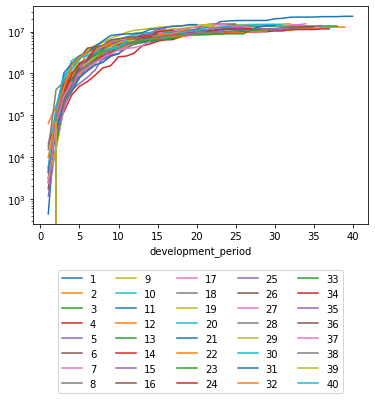

In [20]:
# Inspect claims development by occurrence period

(df_triangle_sort
    .pivot(index = "development_period", columns = "occurrence_period", values = "payments_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

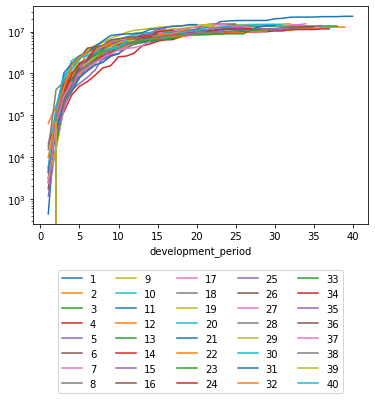

In [21]:
(df_triangle_sort
    .pivot(index = "development_period", columns = "occurrence_period", values = "payments_cumulative")
    .plot(logy=True)
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=5)

In [22]:
### 40 is the (hard-coded) cut-off as set out previously
### Get the diagonals in the cumulative IBNR triangle, which represents cumulative payments for a particular
### occurrence period

triangle_diagonal_interim = df_triangle_sort['payments_cumulative'][df_triangle_sort['payment_period'] == 40] \
                                                         .reset_index(drop = True)

triangle_diagonal_interim = pd.DataFrame(triangle_diagonal_interim).rename(columns = {'payments_cumulative': 'diagonal'})

triangle_diagonal = triangle_diagonal_interim.iloc[::-1].reset_index(drop = True)

In [23]:
### Sum cumulative payments by development period - to be used to calculate CDFs later

development_period_sum_interim = df_triangle_sort.groupby(by = 'development_period').sum()
development_period_sum = development_period_sum_interim['payments_cumulative'].reset_index(drop = True)

development_period_sum = pd.DataFrame(development_period_sum).rename(columns = {'payments_cumulative': 'dev_period_sum'})

In [24]:
# Merge two dataframes

df_cdf_interim = pd.concat([triangle_diagonal, development_period_sum], axis = 1)


In [25]:
#df_cdf_interim.head()

In [30]:
## dev_period_sum_alt column is to ensure the claims for two consecutive periods have the same number
## of levels/elements (and division of these two claims columns give the CDF)

df_cdf_interim['dev_period_sum_alt'] = df_cdf_interim['dev_period_sum'] - df_cdf_interim['diagonal']

In [33]:
### Show numbers in ,000 so they fit in the print

df_cdf = df_cdf_interim / 1000
df_cdf.head()

,diagonal,dev_period_sum,dev_period_sum_alt
0,16.522339,185.889642,169.367303
1,69.383492,3175.258309,3105.874818
2,357.030858,14478.493908,14121.463050
3,620.621166,30945.250969,30324.629803
4,1306.026932,53178.458717,51872.431785


In [34]:
### Calculate CDFs and IBNR

df_cdf['dev_period_sum_shift'] = df_cdf['dev_period_sum'].shift(-1)
df_cdf['CDF'] = df_cdf['dev_period_sum_shift'] / df_cdf['dev_period_sum_alt']
df_cdf['IBNR'] = df_cdf['diagonal'] *  df_cdf['CDF'] - df_cdf['diagonal']

In [35]:
df_cdf

,diagonal,dev_period_sum,dev_period_sum_alt,dev_period_sum_shift,CDF,IBNR
0,16.522339,185.889642,169.367303,3175.258309,18.747764,2.932346e+02
1,69.383492,3175.258309,3105.874818,14478.493908,4.661648,2.540579e+02
2,357.030858,14478.493908,14121.463050,30945.250969,2.191363,4.253533e+02
3,620.621166,30945.250969,30324.629803,53178.458717,1.753639,4.677244e+02
4,1306.026932,53178.458717,51872.431785,73296.602164,1.413017,5.394107e+02
5,2324.416373,73296.602164,70972.185791,96164.725611,1.354964,8.250831e+02
6,3881.703186,96164.725611,92283.022426,117681.250228,1.275221,1.068326e+03
7,3601.493888,117681.250228,114079.756340,140442.547454,1.231091,8.322724e+02
8,5105.714463,140442.547454,135336.832990,150703.802943,1.113546,5.797340e+02
9,2977.453115,150703.802943,147726.349828,170044.443445,1.151077,4.498255e+02


In [20]:
## Export to HTML

%%shell
jupyter nbconvert --to html /content/SQL_Query_for_Triangles_jp_jc.ipynb

[NbConvertApp] Converting notebook /content/SQL_Query_for_Triangles_jp_jc.ipynb to html
[NbConvertApp] Writing 554854 bytes to /content/SQL_Query_for_Triangles_jp_jc.html


In [21]:
#!pandoc /content/SQL_Query_for_Triangles_jp_jc.html -s -o test.docx

In [28]:
pd.DataFrame(IBNR_triangle_cumulative/1000).round(0)

development_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
occurrence_period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,47.0,440.0,625.0,1326.0,1587.0,1920.0,2185.0,2790.0,2934.0,4022.0,5022.0,5439.0,5603.0,6282.0,6701.0,6858.0,7857.0,9210.0,10895.0,12255.0,13365.0,17229.0,17816.0,18258.0,18328.0,18358.0,18371.0,18398.0,20170.0,20677.0,21945.0,22151.0,22157.0,22157.0,22666.0,22722.0,22722.0,23135.0,23135.0
2,64.0,168.0,303.0,597.0,1084.0,3889.0,4272.0,4420.0,4673.0,5212.0,5298.0,5855.0,6566.0,6923.0,7054.0,7223.0,7392.0,7667.0,8434.0,8627.0,8812.0,8848.0,8861.0,9443.0,9509.0,9789.0,9800.0,9984.0,10437.0,10523.0,10532.0,10929.0,11644.0,11733.0,11861.0,12391.0,12741.0,12754.0,12845.0,0.0
3,3.0,46.0,203.0,482.0,1020.0,1422.0,2113.0,2556.0,3278.0,4114.0,4489.0,4942.0,5453.0,6346.0,7395.0,7584.0,8185.0,8461.0,8647.0,10312.0,10539.0,10544.0,11024.0,11805.0,12693.0,12774.0,13191.0,13239.0,13505.0,13505.0,13526.0,13526.0,13526.0,13546.0,13546.0,13546.0,13546.0,13546.0,0.0,0.0
4,0.0,62.0,119.0,305.0,491.0,637.0,906.0,1354.0,1529.0,2500.0,2595.0,3045.0,4530.0,5027.0,5848.0,6313.0,6433.0,7674.0,8298.0,8433.0,8504.0,8525.0,8941.0,9345.0,9840.0,9852.0,9901.0,9901.0,9901.0,10370.0,10370.0,10985.0,11183.0,11183.0,11183.0,11566.0,11566.0,0.0,0.0,0.0
5,5.0,60.0,325.0,528.0,976.0,1239.0,1578.0,1893.0,2643.0,2904.0,5246.0,5791.0,6055.0,6424.0,6750.0,7129.0,7435.0,7819.0,8532.0,9068.0,9562.0,10706.0,10807.0,11375.0,11412.0,11440.0,11440.0,11712.0,11712.0,11822.0,12410.0,12432.0,12519.0,12519.0,12842.0,13886.0,0.0,0.0,0.0,0.0
6,4.0,122.0,659.0,1073.0,1450.0,2127.0,3211.0,4038.0,4892.0,5097.0,5262.0,5681.0,6627.0,7112.0,7480.0,7969.0,8490.0,9119.0,9223.0,9750.0,9862.0,9951.0,10073.0,10077.0,10277.0,10298.0,10352.0,10727.0,10727.0,10795.0,10795.0,12696.0,12696.0,12886.0,13051.0,0.0,0.0,0.0,0.0,0.0
7,0.0,52.0,173.0,451.0,828.0,1354.0,1851.0,2548.0,3280.0,3909.0,4255.0,5469.0,5847.0,6446.0,6599.0,7312.0,8114.0,8301.0,8867.0,9161.0,10179.0,10363.0,10527.0,12782.0,12922.0,13594.0,13897.0,13955.0,13975.0,13986.0,14027.0,14500.0,14500.0,15375.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,29.0,212.0,550.0,833.0,1176.0,2359.0,3261.0,4429.0,4839.0,5060.0,5830.0,5956.0,6128.0,6926.0,7158.0,7474.0,8486.0,8750.0,8994.0,9313.0,9368.0,9951.0,10002.0,10190.0,10846.0,11112.0,11127.0,11150.0,11150.0,11644.0,11956.0,12015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,133.0,349.0,1723.0,2506.0,3302.0,3767.0,4741.0,5295.0,5795.0,6357.0,9091.0,9303.0,9524.0,10177.0,10969.0,11617.0,11769.0,12434.0,12843.0,13234.0,13543.0,13620.0,13722.0,14403.0,14665.0,14792.0,14953.0,14967.0,14980.0,15097.0,15415.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
